# Notebook for Converting photons to SiPM pulse

In [49]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plot
import uproot as up

In [19]:
class DetectorResponse:
    def __init__(self, 
                 sipm_time_resolution=0.1e-9,    # SiPM timing jitter
                 pde=0.4,                        # Photon Detection Efficiency
                 gain=1e6,                       # SiPM gain
                 gain_variation=0.1,             # Relative gain variation
                 sampling_rate=1e9,              # 1 GSa/s
                 noise_rms=1e-3,                 # Electronics noise
                 dark_rate=1e6):                 # Dark count rate in Hz
        
        self.sipm_time_resolution = sipm_time_resolution
        self.pde = pde
        self.gain = gain
        self.gain_variation = gain_variation
        self.sampling_rate = sampling_rate
        self.noise_rms = noise_rms
        self.dark_rate = dark_rate
        
    def process_photons(self, photon_times):
        # Apply PDE - randomly select photons based on detection efficiency
        detected_mask = np.random.random(len(photon_times)) < self.pde
        detected_times = photon_times[detected_mask]
        
        # Add timing jitter to each detected photon
        smeared_times = detected_times + np.random.normal(0, self.sipm_time_resolution, len(detected_times))
        
        # Simulate gain variation for each photon
        gains = np.random.normal(self.gain, self.gain * self.gain_variation, len(smeared_times))
        
        return smeared_times, gains
    
    def generate_pulse(self, photon_times, time_window=100e-9):
        # Process photons through detector
        detected_times, gains = self.process_photons(photon_times)
        
        # Create time axis
        num_samples = int(time_window * self.sampling_rate)
        time_axis = np.linspace(0, time_window, num_samples)
        
        # Generate pulse shape
        pulse = np.zeros(num_samples)
        
        # Single photon response parameters
        rise_time = 1e-9  # 1 ns rise time
        fall_time = 10e-9  # 10 ns fall time
        
        # Generate pulse shape for each photon
        for t, g in zip(detected_times, gains):
            if 0 <= t <= time_window:
                idx = int(t * self.sampling_rate)
                time_from_photon = time_axis[idx:] - t
                
                # Simplified double exponential pulse shape
                photon_pulse = g * (np.exp(-time_from_photon/fall_time) - np.exp(-time_from_photon/rise_time))
                photon_pulse[time_from_photon < 0] = 0
                
                pulse[idx:] += photon_pulse[:len(pulse[idx:])]
        
        # Add noise
        noise = np.random.normal(0, self.noise_rms, num_samples)
        
        # Add dark counts
        expected_dark_counts = int(time_window * self.dark_rate)
        dark_times = np.random.uniform(0, time_window, expected_dark_counts)
        for t in dark_times:
            idx = int(t * self.sampling_rate)
            if idx < num_samples:
                dark_gain = np.random.normal(self.gain, self.gain * self.gain_variation)
                time_from_dark = time_axis[idx:] - t
                dark_pulse = dark_gain * (np.exp(-time_from_dark/fall_time) - np.exp(-time_from_dark/rise_time))
                dark_pulse[time_from_dark < 0] = 0
                pulse[idx:] += dark_pulse[:len(pulse[idx:])]
        
        final_pulse = pulse + noise
        
        return time_axis, final_pulse
    
    def get_pulse_features(self, time_axis, pulse):
        # Find basic pulse features
        peak_amplitude = np.max(pulse)
        total_charge = np.trapezoid(pulse, time_axis)
        
        # Time to threshold (10% of peak)
        threshold = 0.1 * peak_amplitude
        threshold_crossed = np.where(pulse > threshold)[0]
        time_to_threshold = time_axis[threshold_crossed[0]] if len(threshold_crossed) > 0 else None
        
        # Rise time (10% to 90%)
        if peak_amplitude > 0:
            idx_10 = np.where(pulse > 0.1 * peak_amplitude)[0][0]
            idx_90 = np.where(pulse > 0.9 * peak_amplitude)[0][0]
            rise_time = time_axis[idx_90] - time_axis[idx_10]
        else:
            rise_time = None
        
        # FWHM
        half_max_crossed = np.where(pulse > 0.5 * peak_amplitude)[0]
        if len(half_max_crossed) >= 2:
            fwhm = time_axis[half_max_crossed[-1]] - time_axis[half_max_crossed[0]]
        else:
            fwhm = None
        
        return {
            'peak_amplitude': peak_amplitude,
            'total_charge': total_charge,
            'time_to_threshold': time_to_threshold,
            'rise_time': rise_time,
            'fwhm': fwhm
        }

# Example usage
def example_usage():
    # Example photon times (replace this with your actual photon times)
    num_photons = 100
    example_times = np.sort(np.random.uniform(0, 20e-9, num_photons))
    
    detector = DetectorResponse()
    time_axis, pulse = detector.generate_pulse(example_times)
    features = detector.get_pulse_features(time_axis, pulse)
    
    # Print features
    print("\nPulse features:")
    for key, value in features.items():
        if isinstance(value, (int, float)):
            if 'time' in key:
                print(f"{key}: {value*1e9:.2f} ns")
            else:
                print(f"{key}: {value:.2e}")
    
    return time_axis, pulse, features

# Run example



Pulse features:
peak_amplitude: 1.47e+07
total_charge: 2.95e-01
time_to_threshold: 5.05 ns
rise_time: 14.14 ns
fwhm: 1.72e-08


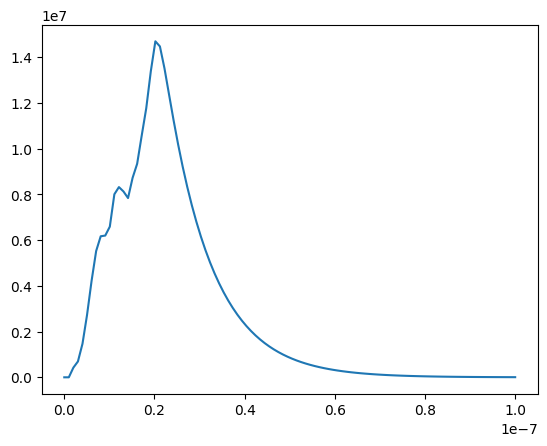

In [22]:
time_axis, pulse, features = example_usage()
plot.plot(time_axis,pulse);

# Constant Fraction

In [106]:
import numpy as np
from scipy import signal, interpolate

class DetectorResponse:
    def __init__(self, 
                 sipm_time_resolution=0.1e-9,    # SiPM timing jitter
                 pde=0.4,                        # Photon Detection Efficiency
                 gain=1e6,                       # SiPM gain
                 gain_variation=0.1,             # Relative gain variation
                 sampling_rate=2.5e9,            # 2.5 GSa/s
                 noise_rms=1e-3,                 # Electronics noise
                 dark_rate=1e6,                  # Dark count rate in Hz
                 crosstalk_prob=0.1):            # Optical crosstalk probability
        
        self.sipm_time_resolution = sipm_time_resolution
        self.pde = pde
        self.gain = gain
        self.gain_variation = gain_variation
        self.sampling_rate = sampling_rate
        self.noise_rms = noise_rms
        self.dark_rate = dark_rate
        self.crosstalk_prob = crosstalk_prob
        
        # CFD parameters
        self.cfd_fraction = 0.2
        self.cfd_delay = 1e-9
        
    def process_photons(self, photon_times):
        # Apply PDE - randomly select photons based on detection efficiency
        detected_mask = np.random.random(len(photon_times)) < self.pde
        detected_times = photon_times[detected_mask]
        
        # Add timing jitter to each detected photon
        smeared_times = detected_times + np.random.normal(0, self.sipm_time_resolution, len(detected_times))
        
        # Simulate gain variation for each photon
        gains = np.random.normal(self.gain, self.gain * self.gain_variation, len(smeared_times))
        
        # Simulate optical crosstalk
        crosstalk_mask = np.random.random(len(smeared_times)) < self.crosstalk_prob
        crosstalk_times = smeared_times[crosstalk_mask] + np.random.normal(0, 0.1e-9, np.sum(crosstalk_mask))
        crosstalk_gains = np.random.normal(self.gain, self.gain * self.gain_variation, len(crosstalk_times))
        
        # Combine original and crosstalk photons
        all_times = np.concatenate([smeared_times, crosstalk_times])
        all_gains = np.concatenate([gains, crosstalk_gains])
        
        return all_times, all_gains
    
    def generate_pulse(self, photon_times, time_window=100e-9):
        # Process photons through detector
        detected_times, gains = self.process_photons(photon_times)
        
        # Create time axis
        num_samples = int(time_window * self.sampling_rate)
        time_axis = np.linspace(0, time_window, num_samples)
        dt = time_axis[1] - time_axis[0]
        
        # Generate pulse shape
        pulse = np.zeros(num_samples)
        
        # Single photon response parameters
        rise_time = 1e-9
        fall_time = 10e-9
        
        # Generate pulse shape for each photon
        for t, g in zip(detected_times, gains):
            if 0 <= t <= time_window:
                idx = int(t / dt)
                time_from_photon = time_axis[idx:] - t
                
                # Double exponential pulse shape
                photon_pulse = g * (np.exp(-time_from_photon/fall_time) - np.exp(-time_from_photon/rise_time))
                photon_pulse[time_from_photon < 0] = 0
                
                if idx < len(pulse):
                    pulse[idx:] += photon_pulse[:len(pulse[idx:])]
        
        # Add dark counts
        expected_dark_counts = int(time_window * self.dark_rate)
        dark_times = np.random.uniform(0, time_window, expected_dark_counts)
        dark_gains = np.random.normal(self.gain, self.gain * self.gain_variation, len(dark_times))
        
        for t, g in zip(dark_times, dark_gains):
            idx = int(t / dt)
            if idx < num_samples:
                time_from_dark = time_axis[idx:] - t
                dark_pulse = g * (np.exp(-time_from_dark/fall_time) - np.exp(-time_from_dark/rise_time))
                dark_pulse[time_from_dark < 0] = 0
                pulse[idx:] += dark_pulse[:len(pulse[idx:])]
        
        # Add electronic noise
        noise = np.random.normal(0, self.noise_rms, num_samples)
        final_pulse = pulse + noise
        
        return time_axis, final_pulse

class TimingDiscriminator:
    def __init__(self, cfd_fraction=0.2, cfd_delay=1e-9):
        self.fraction = cfd_fraction
        self.delay = cfd_delay
    
    def fixed_threshold(self, time_axis, pulse, threshold_fraction=0.1):
        threshold = threshold_fraction * np.max(pulse)
        crossings = np.where(pulse > threshold)[0]
        
        if len(crossings) == 0:
            return None
        
        if crossings[0] > 0:
            # Interpolate for more precise timing
            t0, t1 = time_axis[crossings[0]-1], time_axis[crossings[0]]
            v0, v1 = pulse[crossings[0]-1], pulse[crossings[0]]
            slope = (v1 - v0) / (t1 - t0)
            crossing_time = t0 + (threshold - v0) / slope
            return crossing_time
        return time_axis[crossings[0]]

    def constant_fraction(self, time_axis, pulse):
        dt = time_axis[1] - time_axis[0]
        delay_samples = int(self.delay / dt)
        
        delayed_pulse = np.roll(pulse, delay_samples)
        delayed_pulse[:delay_samples] = 0
        
        attenuated_pulse = self.fraction * pulse
        cfd_signal = delayed_pulse - attenuated_pulse
        
        zero_crossings = np.where(np.diff(np.signbit(cfd_signal)))[0]
        
        if len(zero_crossings) == 0:
            return None
        
        if zero_crossings[0] > 0:
            # Interpolate for more precise timing
            t0, t1 = time_axis[zero_crossings[0]], time_axis[zero_crossings[0]+1]
            v0, v1 = cfd_signal[zero_crossings[0]], cfd_signal[zero_crossings[0]+1]
            slope = (v1 - v0) / (t1 - t0)
            crossing_time = t0 - v0 / slope
            return crossing_time
        return time_axis[zero_crossings[0]]

def analyze_pulse(time_axis, pulse, discriminator):
    # Basic features
    peak_amplitude = np.max(pulse)
    total_charge = np.trapezoid(pulse, time_axis)
    
    # Timing measurements
    fixed_threshold_time = discriminator.fixed_threshold(time_axis, pulse)
    cfd_time = discriminator.constant_fraction(time_axis, pulse)
    
    # Other features
    noise_level = np.std(pulse[:int(len(pulse)/10)])  # Use first 10% of samples for noise estimation
    
    snr = peak_amplitude / noise_level if noise_level > 0 else float('inf')
    
    return {
        'peak_amplitude': peak_amplitude,
        'total_charge': total_charge,
        'fixed_threshold_time': fixed_threshold_time,
        'cfd_time': cfd_time,
        'noise_level': noise_level,
        'snr': snr
    }

# Example usage
def run_simulation(photon_times):
    # Create detector and timing discriminator
    detector = DetectorResponse()
    discriminator = TimingDiscriminator()
    
    # Generate photon times (replace this with your actual photon times)
    
    # Generate pulse with all detector effects
    time_axis, pulse = detector.generate_pulse(photon_times)
    
    # Analyze pulse
    results = analyze_pulse(time_axis, pulse, discriminator)
    
    # Print results
    for key, value in results.items():
        if isinstance(value, float):
            if 'time' in key:
                print(f"{key}: {value*1e9:.2f} ns")
            else:
                print(f"{key}: {value:.2e}")
    
    return time_axis, pulse, results

In [112]:
uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/September_12/run_1/mu_0_8_10GeV_theta90_origin_250events_file_0.edm4hep.root:events"
events = up.open(uproot_path)
times = events["HcalBarrelHits/HcalBarrelHits.time"].array(library='np')[10]
times_seconds = times * (10 ** -9)
min_times = min(times_seconds)
adjusted_times = times_seconds - min_times

peak_amplitude: 2.89e+07
total_charge: 4.52e-01
fixed_threshold_time: 1.35 ns
cfd_time: 0.00 ns
noise_level: 1.02e+07
snr: 2.82e+00


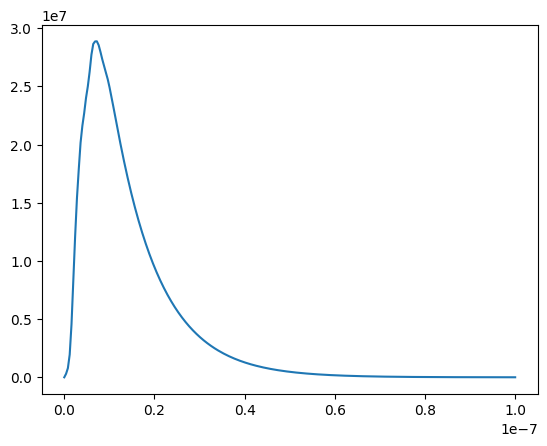

In [113]:
time_axis, pulse, results = run_simulation(adjusted_times)

plot.plot(time_axis,pulse);